# Machine Learning

## Modulo 1 - Classificazione di un Dataset

### Import dei moduli necessari

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import csv, random
from collections import Counter

In [ ]:
print("Hello")

### Preparazione del dataset
Il file ottenuto a seguito di analisi in Radatools non è leggibile direttamente da Cytoscape, pertanto il seguente codice crea un nuovo file ottimizzato per la lettura da parte di Cytoscape.

- *"Communities-unfixed.txt"* è il file ottenuto dalla rimozione dell'intestazione del file **Communities-fb-pages.txt**.
- *"Nodes-paired.txt"* è il file ottenuto dalla rimozione dell'intestazione del file **Links-fb-pages.net**.

Dalla lettura del file delle comunità, si genera il file csv che lega l'id dello show con la comunità,

In [2]:
with open("2-Output/2-radatools_prepared/Communities-unfixed.txt") as file:
    data = csv.reader(file)
    comm_id = 1
    comm_dict = dict()
    
    for comm in data:
        splitted_row = comm[0].split(':')[1]
        splitted_row = splitted_row.split(' ')[1:]
        for node in splitted_row:
            comm_dict[node] = comm_id
        comm_id += 1

with open("2-Output/3-py_elaborated/Communities-fixed.csv", 'w') as file:
    data = csv.writer(file)
    data.writerow(['show_id', 'community'])
    for v,k in comm_dict.items():
        data.writerow([v,k])

La corrispondenza degli ID è inoltre sfalsata a causa della diversa assegnazione degli ID da parte di *Radatools*, per cui è necessario prima di tutto allineare l'ID degli show televisivi originali con quelli modifciati e successivamente si applica alle comunità.

In [3]:
with open("2-Output/3-py_elaborated/Communities-fixed.csv") as file1:
    with open("2-Output/2-radatools_prepared/Nodes-paired.txt") as file2:
        with open("2-Output/1-radatools_created/Nodes-fb-pages-tvshow.txt") as file3:
            comm_df = pd.read_csv(file1, header=0, sep=',')
            ids_df  = pd.read_csv(file2, header=0, sep=' ')
            tv_df   = pd.read_csv(file3, header=0, sep='\t')

tv_df_reindex = pd.merge(tv_df, ids_df, on="id").drop('id', axis=1).rename(columns={'new_id': 'show_id'})
comm_df_named = pd.merge(tv_df_reindex, comm_df, on="show_id")

comm_df_named
ids_df

,new_id,id
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
...,...,...
3798,3799,3886
3799,3800,3887
3800,3801,3888
3801,3802,3889


Adesso, bisogna aggiungere i link al DataFrame, con l'attenzione che anche questi siano correttamente indicizzati.

In [4]:
with open("2-Output/1-radatools_created/Links-fb-pages-tvshow.txt") as file:
    link_df =  pd.read_csv(file, names = ['id_src', 'id_dest'], sep='\t')
link_df

# Qui si separa il DataFrame in due Series per modificare gli ID di ciascuno
src = pd.Series(link_df['id_src'].rename('id'))
dest = pd.Series(link_df['id_dest'].rename('id'))

src_reindex = []
dest_reindex = []

for row in src:
    src_reindex.append(ids_df[ids_df['id'] == row]['new_id'].values)
    dest_reindex.append(ids_df[ids_df['id'] == row]['new_id'].values)

s = pd.Series(np.concatenate(src_reindex, axis=0), name = 'show_id')
d = pd.Series(np.concatenate(dest_reindex, axis=0), name = 'link_to_id')

# Quindi vengono riuniti in un DataFrame con gli ID modificati
link_reindex = pd.concat([s,d], axis = 1)

# Infine, si popola il DataFrame delle comunità
comm_df_named_linked = pd.merge(link_reindex, comm_df_named, on="show_id")
comm_df_named_linked

# E viene salvato in un file csv
with open("2-Output/3-py_elaborated/Communities-with-names.csv", 'w') as file:
    comm_df_named_linked.to_csv(file)

### Simulated Annealing
Si implementa adesso il *simulated annealing* per la classificazione del dataset in **due** comunità.

Si definiscono prima di tutto i parametri necessari per il calcolo della **modularità**.

In [5]:
net = link_reindex                                    # Rete (id source, id destination)
net_unlisted =  list(link_reindex['show_id']) + \
                list(link_reindex['link_to_id'])
nodes = sorted(set(net_unlisted))                     # Lista dei Nodi
n = len(nodes)                                        # Numero di Nodi
L = len(net)                                          # Numero di Link
Ki = Counter(net_unlisted)                            # Grado di ogni vertice

#### Calcolo della modularità

Si crea un generatore di soluzioni random che assegna alla lista dei nodi la comunità 1 o 2.

In [6]:
random.seed(1)

def calculate_solution(n):
    return list(np.random.choice([1, 2], n, replace=True))

Si crea inoltre una funzione per il calcolo della **modularità**.

In [7]:
def calculate_modularity(solution):
    
    # Applicazione della soluzione generata ai nodi (nel dataframe dei link)
    links_between_comm = np.array([ [solution[net.iloc[i,0]-1], solution[net.iloc[i,1]-1]] for i in range(L) ])
    
    e = [ [i == link[0] & link[1] == i for link in links_between_comm].count(True) for i in [1,2] ]
    er = [d/L for d in e]

    # Calcolo del grado medio
    a1 = 0
    a2 = 0

    for i in range(n):
        node = i
        comm = solution[i]

        # Calcolo del grado di ogni comunità
        if comm == 1:
            a1 += Ki[node]
        else:
            a2 += Ki[node]

    ar2 = [(d / (2 * L))**2 for d in [a1, a2]]
    modularity = sum([er[i] - ar2[i] for i in [0,1]])

    return modularity

Si definisce infine una funzione che restituisce il valore della **Temperatura** ad ogni iterazione.

Per farlo bisogna prima calcolare i valori estremi che deve assumere la temperatura, ovvero calcolando la modularità per un numero limitato di simulazioni (es. 200) e calcolando la media delle distanze della modularità.

In [8]:
# Numero di simulazioni per il calcolo della temperatura
nSim = 200
modularity_vec = [calculate_modularity(calculate_solution(n)) for i in range(nSim)]
distance = [abs(modularity_vec[i] - modularity_vec[j]) for i in range(nSim-1) for j in range(i+1, nSim)]
mean_modularity = np.mean(distance)

# Valore iniziale e finale della Temperatura
T0 = 100 * mean_modularity
Tf = 0.01 * mean_modularity

# Numero di simulazioni per il calcolo della modularità
nSim = 1000

A = T0
B = np.log(Tf / A) / nSim
def Temp(n):
    return A * np.exp(B * (n + 1))

Si inizializzano la soluzione e la modularità di partenza.

Si procede quindi all'iterazione per un numero di simulazioni pari a ***nSim***.

In [9]:
sol = calculate_solution(n)
modularityBest = calculate_modularity(sol)
modularities = [modularityBest]

for t in range(nSim):
    if t in range(-1,999,5):
        perc = round(((t+1)/nSim*100),2)
        print(f'Percentage:\t {perc}% (# {t+1}/{nSim})')
    
    solNew = calculate_solution(n)
    modNew = calculate_modularity(solNew)

    if modNew > modularityBest:
        sol = solNew
        modularityBest = modNew
    else:
        diff = modularityBest - modNew
        p = np.exp(-diff / Temp(t))
        randNum = np.random.uniform()
        if randNum <= p:
            sol = solNew
            modularityBest = modNew
    modularities.append(modularityBest)

Percentage:	 0.5% (# 5/1000)
Percentage:	 1.0% (# 10/1000)
Percentage:	 1.5% (# 15/1000)
Percentage:	 2.0% (# 20/1000)
Percentage:	 2.5% (# 25/1000)
Percentage:	 3.0% (# 30/1000)
Percentage:	 3.5% (# 35/1000)
Percentage:	 4.0% (# 40/1000)
Percentage:	 4.5% (# 45/1000)
Percentage:	 5.0% (# 50/1000)
Percentage:	 5.5% (# 55/1000)
Percentage:	 6.0% (# 60/1000)
Percentage:	 6.5% (# 65/1000)
Percentage:	 7.0% (# 70/1000)
Percentage:	 7.5% (# 75/1000)
Percentage:	 8.0% (# 80/1000)
Percentage:	 8.5% (# 85/1000)
Percentage:	 9.0% (# 90/1000)
Percentage:	 9.5% (# 95/1000)
Percentage:	 10.0% (# 100/1000)
Percentage:	 10.5% (# 105/1000)
Percentage:	 11.0% (# 110/1000)
Percentage:	 11.5% (# 115/1000)
Percentage:	 12.0% (# 120/1000)
Percentage:	 12.5% (# 125/1000)
Percentage:	 13.0% (# 130/1000)
Percentage:	 13.5% (# 135/1000)
Percentage:	 14.0% (# 140/1000)
Percentage:	 14.5% (# 145/1000)
Percentage:	 15.0% (# 150/1000)
Percentage:	 15.5% (# 155/1000)
Percentage:	 16.0% (# 160/1000)
Percentage:	 16

Visualizzazione della modularità.

In [10]:
print(f'Best modularity found is: \t {round(modularityBest,4)}')

Best modularity found is: 	 0.0132


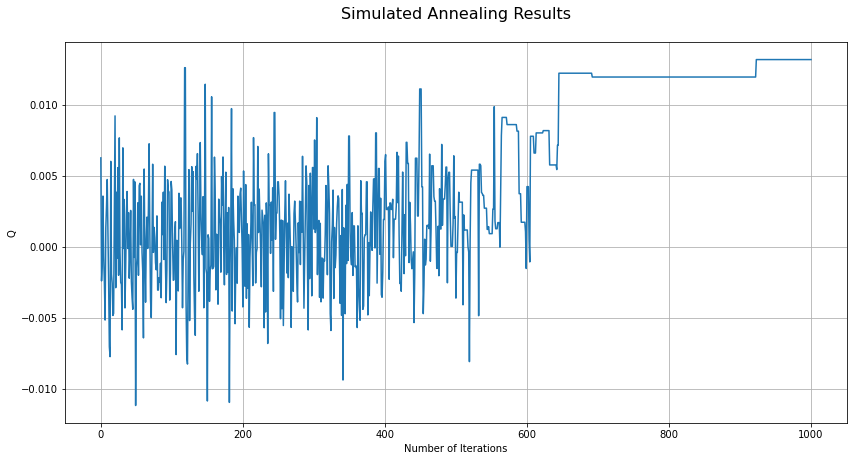

In [11]:
fig = plt.figure(figsize = (14,7))
plt.plot(modularities)
plt.title('Simulated Annealing Results\n', fontdict={'fontsize': 16})
plt.xlabel('Number of Iterations')
plt.ylabel('Q')
plt.grid()
plt.savefig("2-Output/3-py_elaborated/Simulated Annealing.png", format='png')

#### Salvataggio del Linkset finale

In [12]:
solBest = sol                                                                               # Questa è la soluzione ottenuta all'ultimo step del simulated annealing
linksBest = link_reindex                                                                    # Si inizializza il linkset definitivo a partire dall'ultimo linkset

linksBest['community'] = [solBest[i-1] for i in link_reindex['show_id']]                    # La soluzione è quindi applicata al Linkset

with open("2-Output/3-py_elaborated/Linkset-simulated-annealing.csv", 'w') as file:         # Il linkset è infine esportato in CSV per Cytoscape
    linksBest.to_csv(file)

linksBest

,show_id,link_to_id,community
0,1,1824,1
1,1,1731,1
2,1,15,1
3,1,2516,1
4,2,1001,1
...,...,...,...
17257,3744,3761,2
17258,3748,3760,1
17259,1231,125,2
17260,3790,3798,2


### Conclusioni

Si riporta qui la serie di operazioni per valutare la bontà delle due classificazioni: la prima ottenuta con *Radatools* e la seconda con il *Simulated Annealing*.

In [16]:
linksBest = linksBest.rename(columns = {'community':'community_SA'})
communityComparison = pd.merge(linksBest, comm_df_named_linked, on="show_id").drop_duplicates()

# Si raccolgono le 482 comunità in due liste (una per ognuna delle due comunità)
comm1 = communityComparison[communityComparison['community_SA'] == 1]['community']
comm2 = communityComparison[communityComparison['community_SA'] == 2]['community']

# Si verifica adesso quante comunità si trovano in entrambe le comunità
shared_comm = [i for i in comm1 if i in comm2]

print(f'Il numero totale delle 482 comunità che si trovano condivise tra la comunità 1 e 2 è pari a {len(shared_comm)}/482 ({round((len(shared_comm)*100/482),2)}%)')


Il numero totale delle 482 comunità che si trovano condivise tra la comunità 1 e 2 è pari a 0/482 (0.0%)
